# Plotting the Sun in 3D projection

In this notebook an example of how to make a full-Sun map using stereoscopic observations from SDO and STEREO-A and B and how to plot this in a 3D projection using plotly is demonstrated. In this example I'm looking at EUV 193/195 Angstrom wavelength channels from SDO/AIA and STEREO/EUVI.

Please check out [SunPy](https://sunpy.org/), and in particular [this example](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_aia_euvi_mosaic.html#sphx-glr-generated-gallery-map-transformations-reprojection-aia-euvi-mosaic-py) from which the full-Sun map generation used here is based on. 

This notebook requires that you have [sunpy](https://sunpy.org/), [astropy](https://www.astropy.org/), [reproject](https://pypi.org/project/reproject/) and [plotly](https://plotly.com/python/) packages installed. 

The steps outlined here:

1.   **Download some data**
Use Fido to search for some data and download it locally. You can use other data too that you already have locally and skip this step.


2. **Load in EUV maps and make full-Sun projection in latitude and longitude**
 We'll load in three maps and inspect them, and look at the relative observer satellite positions to each other. Then we'll reproject these onto a new map which consists of the full latitude and longitude of the Sun.


3. **3D plotting**
We'll then transform this new full-Sun map into a 3D plot by finding the coordinates of each pixel, and then transforming these coordinates into a Heliocentric frame. Then we'll take the x, y, z Cartesian values of these transformed coordinates and plot them on a 3D surface plot with plotly. Note this can be done with _any_ map, not just a full-Sun map! An example of this is also shown at the end.


Things to note:
 * This is processed on the level 1 data, and the map data has _not_ been prepped. If you want to make sure you're fully correct, you should probably look into prepping the data. 
 * You can also play around with the different scalings to help identify different features etc. I've also added a `bytescale` function located in the last cell that should be run before step 3. This is basically the same as the IDL bytescale and is based on the bytescale function that used to be available with scipy but is now deprecated. 

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.colors
import numpy as np 

from sunpy.coordinates import frames, get_body_heliographic_stonyhurst
from sunpy.time import parse_time
from sunpy.net import Fido, attrs as a
import sunpy.map
import sunpy.visualization.colormaps as cm
from sunpy.map.sources.source_type import source_stretch

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import astropy.constants

from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import plotly.graph_objects as go
from plotly.offline import plot

import warnings
warnings.filterwarnings("ignore")

## 1. Download some data

### Lets first get some data to work with

If you already have some data locally then you can use that, otherwise we can use `sunpy.net.Fido` to query and download the data for a given day. You can do this query all together but just to do a step-by-step guide we'll do it seperately.

Here, I'm just choosing a particular date of interest in Nov 2011. I'm downloading just one file from each instrument and saving them to my current working directory.

In [2]:
date = "2011-11-15"

aia_res = Fido.search(a.Time("2011-11-15 00:13", "2011-11-15 23:00"),
                      a.Instrument("AIA"), 
                      a.Wavelength(193*u.angstrom), 
                      a.Sample(24*u.hour))
aia_res

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2011-11-15 00:13:07,2011-11-15 00:13:08,SDO,AIA,FULLDISK,193.0 .. 193.0


In [3]:
stereo = Fido.search(a.Time('2011-11-15', '2011-11-15 00:10:00'),
                     a.Instrument("EUVI"),
                     a.Wavelength(195*u.angstrom))
stereo

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str8,str6,str8,float64
2011-11-15 00:05:30,2011-11-15 00:05:38,STEREO_A,SECCHI,FULLDISK,195.0 .. 195.0
2011-11-15 00:06:31,2011-11-15 00:06:39,STEREO_B,SECCHI,FULLDISK,195.0 .. 195.0


Now we can download these data with `Fido.fetch`, the `path` keyword allows you to define a path for where to save the data. If you don't give anything here it will download it into the path definined within your sunpy config file.

In [4]:
files = Fido.fetch(stereo, aia_res, path="./")

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

In [5]:
print(files)

['20111115_000530_n4eub.fts', 'aia_lev1_193a_2011_11_15t00_13_07_84z_image_lev1.fits', '20111115_000530_n4eua.fts']


## 2. Load in EUV maps and make full-Sun projection in latitude and longitude

We can read the data fits files into a `sunpy.map.Map` and inspect and plot. You can also pass a list of files of `sunpy.map.Map` but here we'll read them in seperately just to help illustrate whats going on.

In [6]:
# read in data (you can skip first part if you already have some data locally)
aia_map = sunpy.map.Map("aia_lev1_193a_2011_11_15t00_13_07_84z_image_lev1.fits")
stereo_a_map = sunpy.map.Map("20111115_000530_n4eua.fts")
stereo_b_map = sunpy.map.Map("20111115_000530_n4eub.fts")

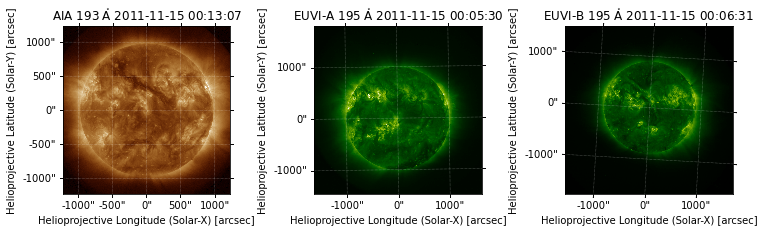

In [7]:
#plot the data
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1, projection=aia_map)
ax2 = fig.add_subplot(1, 3, 2, projection=stereo_a_map)
ax3 = fig.add_subplot(1, 3, 3, projection=stereo_b_map)
aia_map.plot(axes=ax1)
stereo_a_map.plot(axes=ax2)
stereo_b_map.plot(axes=ax3)
plt.subplots_adjust(wspace=0.5)

### Let's plot their positions relative to each other and the Sun 

This can be done using the observer coordinate attribute within each map which holds the information about the satellite position as a SkyCoord object. Here we'll plot it in polar coordinates, but you could also transform to different coordinate frames, and from different observers, and plot in Cartesian too if you fancy.

In [8]:
# you can inspect the observer coordinate of each Map.
print(aia_map.observer_coordinate)

<SkyCoord (HeliographicStonyhurst: obstime=2011-11-15T00:13:07.840): (lon, lat, radius) in (deg, deg, m)
    (-0.01256282, 2.91264711, 1.479967e+11)>


Now lets plot these in a polar plot. We'll also get the position of the Sun (also in Heliographic stonyhurst to show relative positions)

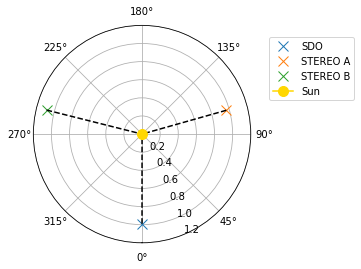

In [9]:
sun = get_body_heliographic_stonyhurst("sun", aia_map.date)

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
    
for m in [aia_map, stereo_a_map, stereo_b_map]:
    ax.plot(m.observer_coordinate.lon.to(u.rad), 
            m.observer_coordinate.radius.to(u.AU), 
            'x', ms=10,
            label=m.observatory)
    
    ax.plot([m.observer_coordinate.lon.to_value(u.rad), sun.lon.to_value(u.rad)], 
            [m.observer_coordinate.radius.to_value(u.AU), sun.radius.to_value(u.AU)],
            ls="dashed", color="k")


ax.plot(sun.lon.to(u.rad), 
            sun.radius.to(u.AU),
            color="gold", 
            marker="o", ms=10, label="Sun")

ax.set_theta_zero_location("S")
ax.set_rlim(0, 1.2)
ax.legend(bbox_to_anchor=(1.5, 0.8), loc="center right")

## Now lets use sunpy and reproject to put these three view points into a single full-sun map

The function below is based on this example which has a more detailed explaination of whats going on:
https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_aia_euvi_mosaic.html#sphx-glr-generated-gallery-map-transformations-reprojection-aia-euvi-mosaic-py



In [10]:
def get_full_map(map1, map2, map3):
    """
    A function that takes three input maps, creates a new wcs and then uses 
    reprojects and co-adds these maps to construct a new map of a single image. 
    
    Parameters
    ----------
    map1, map2, map3 - `sunpy.map.Map`
        The input maps to be reprojected
        
    Returns
    -------
    outmap : `sunpy.map.Map`
        A new map that consists of a single image and WCS in a Heliographic Stonyhurst frame
        with a Plate Carree projection.
    
    """
    
    

    maps = sunpy.map.Map([map1, map2, map3])
    maps = [m.resample((1024, 1024)*u.pix) for m in maps]
    
    shape_out = (180, 360)  
    header = sunpy.map.make_fitswcs_header(shape_out,
                                           SkyCoord(0, 0, unit=u.deg,
                                                    frame="heliographic_stonyhurst",
                                                    obstime=maps[0].date),
                                           scale=[180 / shape_out[0],
                                                  360 / shape_out[1]] * u.deg / u.pix,
                                           wavelength=int(maps[0].meta['wavelnth']) * u.AA,
                                           projection_code="CAR")
    out_wcs = WCS(header)
    coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))
    weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]

    weights = [(w / np.nanmax(w)) ** 3 for w in weights]
    for w in weights:
        w[np.isnan(w)] = 0

    array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                                   input_weights=weights,
                                   reproject_function=reproject_interp,
                                   match_background=True,
                                   background_reference=1)


    outmap = sunpy.map.Map((array, header))

    return outmap
    

Now we can pass out three maps to this function `get_full_map` and return a new map

In [11]:
full_map = get_full_map(aia_map, stereo_a_map, stereo_b_map)

Now we need to update the plot settings of this map to help with the visualization of it. Here we are using the ` sohoeit195` colortable, however with the release if sunpy 2.1 the EUVI specific colortable will be available. But the SOHO one is close enough, and works well.

In [12]:
plot_settings = {"cmap": "sohoeit195", 
                 "norm": ImageNormalize(stretch=source_stretch(full_map.meta, 
                                                               PowerStretch(0.20)))}
full_map.plot_settings = plot_settings
cmap = full_map.cmap
cmap.set_bad(color="k") # set nan values black rather than white

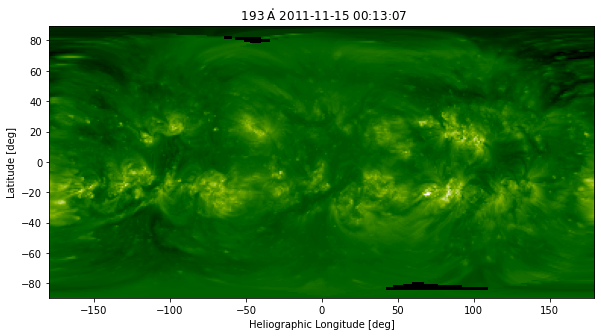

In [13]:
fig, ax= plt.subplots(figsize=(10, 5))
full_map.plot()

# 3. 3D plotting

## Create 3D representation of this full-Sun map

Now from this full Sun map lets get generate the required coords to represent this map in 3D. 

The steps are to get the coordinates of everypoint on the Map and then transform these to a heliocentric frame and get the Cartesian coordinates (i.e. x, y, z).

This can be achieved through the functionality available within the astropy/sunpy coordinate stack and functions within `sunpy.map.maputils`


In [14]:
# first get all coordinates from the Map
all_coords = sunpy.map.maputils.all_coordinates_from_map(full_map)


# then transform these into a Heliocentric frame and in Cartesian 
all_coords_hc = all_coords.transform_to(frames.HeliocentricInertial()).cartesian
# now can pull out the X, Y and Z values in units of radius of the Sun
xx = all_coords_hc.x.to_value(astropy.constants.R_sun)
yy = all_coords_hc.y.to_value(astropy.constants.R_sun)
zz = all_coords_hc.z.to_value(astropy.constants.R_sun)


Now that we have the coordinates, we want to scale the data, as I havent figured out how to scale the colortable in plotly. To do this, I'm just taking the log of the data and then use the `bytescale` function which is defined in the cells at the end of this notebook to get the scaling right! 

In [15]:
print(np.nanmin(np.log10(full_map.data)), np.nanmax(np.log10(full_map.data)))

2.897542957539015 4.194717896087779


In [19]:
# remeber to run the cell at the end of this notebook first
map_values = bytescale(np.log10(full_map.data), 2.4, 4)

Lets just plot these values to see how they look!

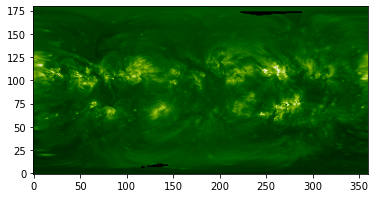

In [20]:
plt.imshow(map_values, cmap="sohoeit195", origin="lower")

## Now well be using plotly which can't take matplotlib colormaps, so need to convert the map colortable to a plotly one

In [ ]:
sohoeit = cm.cm.sohoeit195
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

sohoeit_plotly = matplotlib_to_plotly(sohoeit, 255)

### Now we can use plotly to plot our map! 

In [ ]:
# data to plot
sun_sphere=dict(type='surface',
                  x=xx,
                  y=yy,
                  z=zz,
                  colorscale=sohoeit_plotly,
                  surfacecolor=map_values)



titlecolor = 'white'
bgcolor = 'black'
noaxis=dict(showbackground=False)
layout = go.Layout(title = '3D spherical topography map',
                   titlefont = dict(color=titlecolor),
                   showlegend = False,
                   scene = dict(xaxis=noaxis, 
                                yaxis=noaxis, 
                                zaxis=noaxis),
                   paper_bgcolor = bgcolor,
                   plot_bgcolor = bgcolor)



plot_data=[sun_sphere]
fig = go.Figure(data=plot_data,  layout=layout)
fig.update_layout(title={'text': "SDO/AIA & STEREO-A/B 193/195 Angstrom",
                        'y':0.85,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  font_color=titlecolor,
                  scene = dict(xaxis_title='X (Rsun)',
                               yaxis_title='Y (Rsun)',
                               zaxis_title='Z (Rsun)'),
                 
                  )
fig.show()

# uncomment this to save as a html interactive plot.
# plot(fig, validate = False, filename='3Dsuntest.html',
#     auto_open=True) 

## We can also look at the observer coordinates for each satellite and plot these too!

Here's we'll get the coordinate information from the map header, transform it to the Heliocentric frame like the Sun above and also plot.

In [ ]:
def get_xyz_coord(my_map, val=1):
    """
    Takes a map and returns x, y, z coordinates of the observer position in the Heliocentric frame. 
    The values returned are in units of R_sun scaled to some value `val` - this is just for plotting purposes.
    """
    obs_coord = my_map.observer_coordinate.transform_to(frames.HeliocentricInertial()).cartesian
    x_obs, y_obs, z_obs = obs_coord.x.to_value(val*astropy.constants.R_sun), obs_coord.y.to_value(val*astropy.constants.R_sun), obs_coord.z.to_value(val*astropy.constants.R_sun)
    return x_obs, y_obs, z_obs
    
x_aia, y_aia, z_aia = get_xyz_coord(aia_map, val=100)
x_sta, y_sta, z_sta = get_xyz_coord(stereo_a_map, val=100)
x_stb, y_stb, z_stb = get_xyz_coord(stereo_b_map, val=100)

In [ ]:
sun_sphere=dict(type='surface',
                  x=xx,
                  y=yy,
                  z=zz,
                  colorscale=sohoeit_plotly,
                  surfacecolor=map_values)

titlecolor = 'white'
bgcolor = 'black'

x_sat = [x_aia, x_sta, x_stb]
y_sat = [y_aia, y_sta, y_stb]
z_sat = [z_aia, z_sta, z_stb]
satellite_points = go.Scatter3d(x=x_sat, y=y_sat, z=z_sat, 
                      mode="markers+text", 
                      marker=dict(color="#636EFA"),
                      text=["SDO", "STEREO-A", "STEREO-B"],
                      textfont=dict(color=titlecolor))



noaxis=dict(showbackground=False)
layout = go.Layout(titlefont = dict(color=titlecolor),
                   showlegend = False,
                   scene = dict(xaxis=noaxis, 
                                yaxis=noaxis, 
                                zaxis=noaxis),
                   paper_bgcolor = bgcolor,
                   plot_bgcolor = bgcolor)



plot_data=[sun_sphere, satellite_points]
fig = go.Figure(data=plot_data,  layout=layout)
fig.update_layout(title={'text': "SDO/AIA & STEREO-A/B 193/195 Angstrom",
                        'y':0.85,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  font_color=titlecolor,
                  scene = dict(xaxis_title='X (Rsun)',
                               yaxis_title='Y (Rsun)',
                               zaxis_title='Z (Rsun)'),
                 
                  )
fig.show()

# uncomment this to save as a html interactive plot.
# plot(fig, validate = False, filename='3Dsuntest.html',
#     auto_open=True) 

## Lets just do a 3D plot with just the AIA map.

We first just resample the data to help with time!

In [ ]:

aia_map_resample = aia_map.resample([512, 512]*u.pix)
all_coords_aia = sunpy.map.maputils.all_coordinates_from_map(aia_map_resample)


all_coords_hc_aia = all_coords_aia.transform_to(frames.HeliocentricInertial()).cartesian
# now can pull out the X, Y and Z values in units of radius of the Sun
xx_aia = all_coords_hc_aia.x.to_value(astropy.constants.R_sun)
yy_aia = all_coords_hc_aia.y.to_value(astropy.constants.R_sun)
zz_aia = all_coords_hc_aia.z.to_value(astropy.constants.R_sun)

aia_values = np.log10(aia_map_resample.data)

In [ ]:
fig, ax = plt.subplots()
plt.imshow(aia_values, cmap="sdoaia193")

In [ ]:
aia_193_cmap = matplotlib_to_plotly(cm.cm.sdoaia193, 255)

In [ ]:
# data to plot
sun_sphere=dict(type='surface',
                  x=xx_aia,
                  y=yy_aia,
                  z=zz_aia,
                  colorscale=aia_193_cmap,
                  surfacecolor=aia_values)



titlecolor = 'white'
bgcolor = 'black'
noaxis=dict(showbackground=False)
layout = go.Layout(title = '3D spherical topography map',
                   titlefont = dict(color=titlecolor),
                   showlegend = False,
                   scene = dict(xaxis=noaxis, 
                                yaxis=noaxis, 
                                zaxis=noaxis),
                   paper_bgcolor = bgcolor,
                   plot_bgcolor = bgcolor)



plot_data=[sun_sphere]
fig = go.Figure(data=plot_data,  layout=layout)
fig.update_layout(title={'text': "SDO/AIA",
                        'y':0.85,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                  font_color=titlecolor,
                  scene = dict(xaxis_title='X (Rsun)',
                               yaxis_title='Y (Rsun)',
                               zaxis_title='Z (Rsun)'),
                 
                  )
fig.show()


In [17]:
# Returns a byte-scaled image
def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).

    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.

    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.

    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.

    Examples
    --------
    >>> img = array([[ 91.06794177,   3.39058326,  84.4221549 ],
                     [ 73.88003259,  80.91433048,   4.88878881],
                     [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)

    """
    if data.dtype == np.uint8:
        return data

    if high < low:
        raise ValueError("`high` should be larger than `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data * 1.0 - cmin) * scale + 0.4999
    bytedata[bytedata > high] = high
    bytedata[bytedata < 0] = 0
    return np.cast[np.uint8](bytedata) + np.cast[np.uint8](low)